# Quantum Error Mitigation (QEM) technique: Zero-Noise Extrapolation (ZNE) with Qiskit

$ $

In this notebook, we have implemented a __Quantum Error Mitigation (QEM)__ technique, called __Zero-Noise Extrapolation (ZNE)__, with the quantum software development kit __Qiskit__.

The ZNE is used in quantum computing to mitigate the impact of noise and errors in quantum systems. It is specifically employed to improve the accuracy of quantum algorithms executed on Noisy Intermediate-Scale Quantum (NISQ) devices.

The basic idea behind ZNE involves running the quantum algorithm multiple times with different levels of noise, ranging from low to high. By analyzing the correlation between the noise level and the obtained results, it becomes possible to extrapolate the expected outcome when the noise is completely eliminated or reduced to a negligible level. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time, copy



from qiskit import QuantumCircuit, transpile                   #!pip install qiskit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram                #!pip install qiskit[visualization]

from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError, pauli_error, 
                              depolarizing_error, thermal_relaxation_error)


## Quantum circuit

Our quantum circuit is made of L layers.
Each quantum layer has two parts: 

- The first part is made of the tensor-product of single-qubit rotations around $z$-axis. 

- The second part is made of the tensor-product of controlled-$Z$ gates.


In [2]:
L = 1
n = 3
dim = 2**n

print(f'number of layers = {L}')
print(f'number of qubits = {n}')

angs = np.pi*np.random.rand(L, n)
print(f'angles = {angs}\n')

def generate_QC(L, n, angs):
    qc = QuantumCircuit(n)
    for l in range(L):            # lth layer
        for i in range(n):        # ith qubit
            qc.rz(angs[l, i], i)
        for i in range(n-1):
            qc.cz(i, i+1)
    return qc
            


circ = generate_QC(L, n, angs)
print(circ)    

number of layers = 1
number of qubits = 3
angles = [[0.921603   3.04800896 0.65596705]]

      ┌────────────┐      
q_0: ─┤ Rz(0.9216) ├─■────
      ├───────────┬┘ │    
q_1: ─┤ Rz(3.048) ├──■──■─
     ┌┴───────────┴┐    │ 
q_2: ┤ Rz(0.65597) ├────■─
     └─────────────┘      


## Ideal simulator

         ┌────────────┐       ░ ┌─┐      
   q_0: ─┤ Rz(0.9216) ├─■─────░─┤M├──────
         ├───────────┬┘ │     ░ └╥┘┌─┐   
   q_1: ─┤ Rz(3.048) ├──■──■──░──╫─┤M├───
        ┌┴───────────┴┐    │  ░  ║ └╥┘┌─┐
   q_2: ┤ Rz(0.65597) ├────■──░──╫──╫─┤M├
        └─────────────┘       ░  ║  ║ └╥┘
meas: 3/═════════════════════════╩══╩══╩═
                                 0  1  2 


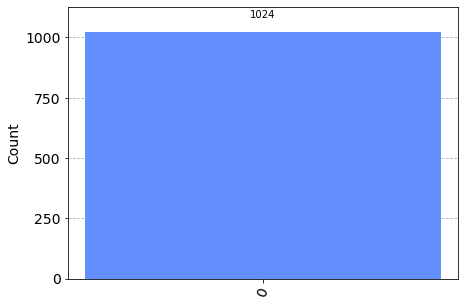

In [3]:
sim_ideal = AerSimulator()

circ_copy = copy.deepcopy(circ)
circ_copy.measure_all()
print(circ_copy)
result_ideal = sim_ideal.run(circ_copy).result()
counts_ideal = result_ideal.get_counts()


counts_ideal_int = {int(z, 2): counts for z, counts in counts_ideal.items()}
plot_histogram(counts_ideal_int)


__The input state $|0\rangle$ is an eigenstate of all the unitary operators in the circuit. So, the true probability $p_0 = 1$, rest of the probabilities are zeros.__

In [4]:
def probabilities(counts):
    prob = []
    keys = list(counts.keys())
    for j in range(dim):
        if j in keys:
            prob.append(counts[j])
        else:
            prob.append(0)
    
    prob = np.array(prob)        
    prob = prob/np.sum(prob)
    return prob


prob_ideal = probabilities(counts_ideal_int)
print(f'estimated prob_ideal = {prob_ideal}') 

estimated prob_ideal = [1. 0. 0. 0. 0. 0. 0. 0.]


## Noise model 

In [5]:
noise_model = NoiseModel()                                    # create an empty noise model

param_ = 0.03
p_ = param_

for i in range(n):
    error = depolarizing_error(param=param_, num_qubits=1)    # add depolarizing error to all single qubit rz gates
    noise_model.add_quantum_error(error, 'rz', [i])
    
    error_1Q = pauli_error([('X', p_), ('I', 1 - p_)])
    error_2Q = error_1Q.tensor(error_1Q)                      # add pauli_error on two-qubit cz gates
    if i < n-1:
        noise_model.add_quantum_error(error_2Q, 'cz', [i, i+1])


print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['rz', 'cz']
  Qubits with noise: [0, 1, 2]
  Specific qubit errors: [('rz', (0,)), ('rz', (1,)), ('rz', (2,)), ('cz', (0, 1)), ('cz', (1, 2))]


## Noisy simulator

         ┌────────────┐       ░ ┌─┐      
   q_0: ─┤ Rz(0.9216) ├─■─────░─┤M├──────
         ├───────────┬┘ │     ░ └╥┘┌─┐   
   q_1: ─┤ Rz(3.048) ├──■──■──░──╫─┤M├───
        ┌┴───────────┴┐    │  ░  ║ └╥┘┌─┐
   q_2: ┤ Rz(0.65597) ├────■──░──╫──╫─┤M├
        └─────────────┘       ░  ║  ║ └╥┘
meas: 3/═════════════════════════╩══╩══╩═
                                 0  1  2 


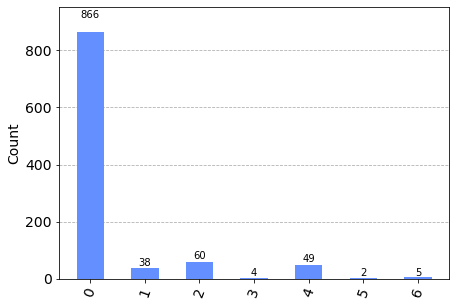

In [6]:
sim_noise = AerSimulator(noise_model=noise_model)            # create noisy simulator backend

circ_copy = copy.deepcopy(circ)
transpiled = transpile(circ_copy, sim_noise)                 # transpile circuit for noisy basis gates
transpiled.measure_all()
print(transpiled)

result_noise = sim_noise.run(transpiled).result()            # run and get counts
counts_noise = result_noise.get_counts()



counts_noise_int = {int(z, 2): counts for z, counts in counts_noise.items()}
plot_histogram(counts_noise_int)

In [7]:
prob_noise = probabilities(counts_noise_int)
print(f'extimated prob_noise = {prob_noise}\n')

print(f'extimated prob_ideal = {prob_ideal}')


extimated prob_noise = [0.84570312 0.03710938 0.05859375 0.00390625 0.04785156 0.00195312
 0.00488281 0.        ]

extimated prob_ideal = [1. 0. 0. 0. 0. 0. 0. 0.]


$ $
# 1st implementation
## Quantum Error Mitigation: Zero-Noise Extrapolation (ZNE)

The basic idea behind this ZNE implementation is repeatedly the noisy quantum circuit $k$ times and the measurement at the end.
Here, $k=1,\cdots,kmax$ acts as a measure of the noise level. As k increase, more and more noise accumulates.


By analyzing the relation between the noise level ($k$) and the obtained probabilities for outcomes 
$0,\cdots,dim-1$, it becomes possible to extrapolate the probabilities when the noise is eliminated (that corresponds to $k=0$). That will be the obtained error mitigated value. 

In [8]:

def repeat_circuit(k):
    print(f'k={k}')
    circ_copy = copy.deepcopy(circ)
    transpiled = transpile(circ_copy, sim_noise)              # transpile circuit for noisy basis gates
    for _ in range(k-1):
        transpiled = transpiled.compose(transpile(circ_copy, sim_noise))
        
    
    transpiled.measure_all()
    print(transpiled)
    result_noise = sim_noise.run(transpiled).result()         # run and get counts
    counts_noise = result_noise.get_counts()
    counts_noise_int = {int(z, 2): counts for z, counts in counts_noise.items()}
    prob_noise = probabilities(counts_noise_int)
    return prob_noise

kmax = 9
ks = []
prob_noise_list = []
for k in range(1, kmax):
    ks.append(k)
    #print(f'k={k}')
    prob_noise_ = repeat_circuit(k)
    prob_noise_list.append(prob_noise_)
    

prob_noise_list = np.array(prob_noise_list)  
prob_noise_list

k=1
         ┌────────────┐       ░ ┌─┐      
   q_0: ─┤ Rz(0.9216) ├─■─────░─┤M├──────
         ├───────────┬┘ │     ░ └╥┘┌─┐   
   q_1: ─┤ Rz(3.048) ├──■──■──░──╫─┤M├───
        ┌┴───────────┴┐    │  ░  ║ └╥┘┌─┐
   q_2: ┤ Rz(0.65597) ├────■──░──╫──╫─┤M├
        └─────────────┘       ░  ║  ║ └╥┘
meas: 3/═════════════════════════╩══╩══╩═
                                 0  1  2 
k=2
         ┌────────────┐   ┌────────────┐                      ░ ┌─┐      
   q_0: ─┤ Rz(0.9216) ├─■─┤ Rz(0.9216) ├────────────────■─────░─┤M├──────
         ├───────────┬┘ │ └────────────┘ ┌───────────┐  │     ░ └╥┘┌─┐   
   q_1: ─┤ Rz(3.048) ├──■───────■────────┤ Rz(3.048) ├──■──■──░──╫─┤M├───
        ┌┴───────────┴┐         │       ┌┴───────────┴┐    │  ░  ║ └╥┘┌─┐
   q_2: ┤ Rz(0.65597) ├─────────■───────┤ Rz(0.65597) ├────■──░──╫──╫─┤M├
        └─────────────┘                 └─────────────┘       ░  ║  ║ └╥┘
meas: 3/═════════════════════════════════════════════════════════╩══╩══╩═
                      

array([[0.86230469, 0.03515625, 0.05957031, 0.00585938, 0.03613281,
        0.        , 0.        , 0.00097656],
       [0.73535156, 0.05664062, 0.12304688, 0.01269531, 0.05664062,
        0.00683594, 0.00683594, 0.00195312],
       [0.62304688, 0.09082031, 0.14453125, 0.01757812, 0.07910156,
        0.02148438, 0.01855469, 0.00488281],
       [0.5625    , 0.08496094, 0.16601562, 0.0234375 , 0.10058594,
        0.01757812, 0.03515625, 0.00976562],
       [0.46679688, 0.1171875 , 0.18652344, 0.03222656, 0.11425781,
        0.03613281, 0.03710938, 0.00976562],
       [0.42675781, 0.10546875, 0.18554688, 0.04785156, 0.1328125 ,
        0.03027344, 0.05175781, 0.01953125],
       [0.39257812, 0.10742188, 0.21582031, 0.05859375, 0.12988281,
        0.02539062, 0.05566406, 0.01464844],
       [0.35742188, 0.13378906, 0.17871094, 0.07617188, 0.1171875 ,
        0.0546875 , 0.06152344, 0.02050781]])

After error mitigation, probability (expectation value) for the outcome 0 = 0.993


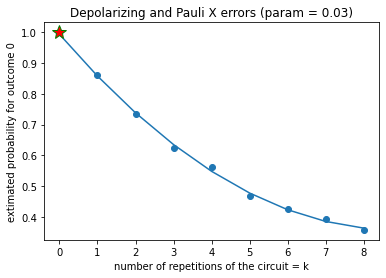

After error mitigation, probability (expectation value) for the outcome 1 = 0.014


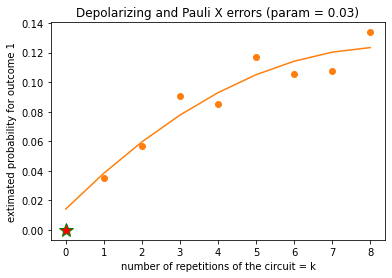

After error mitigation, probability (expectation value) for the outcome 2 = 0.014


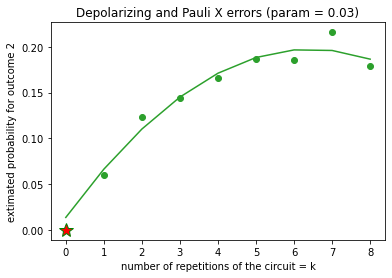

After error mitigation, probability (expectation value) for the outcome 3 = 0.006


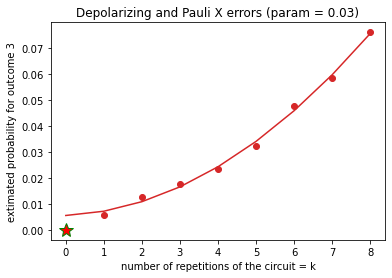

After error mitigation, probability (expectation value) for the outcome 4 = -0.004


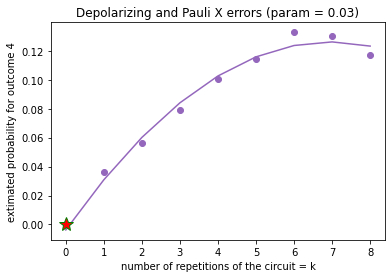

After error mitigation, probability (expectation value) for the outcome 5 = -0.005


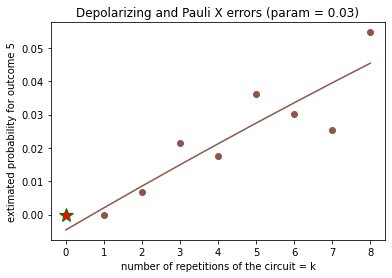

After error mitigation, probability (expectation value) for the outcome 6 = -0.015


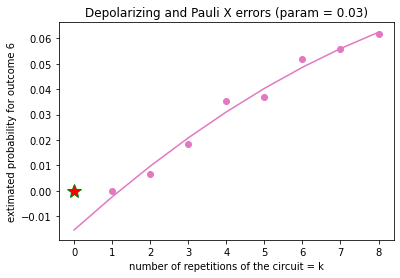

After error mitigation, probability (expectation value) for the outcome 7 = -0.003


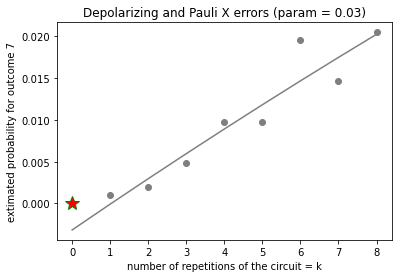

In [9]:
deg = 2

def plot(probs, outcome):
    f = np.poly1d(np.polyfit(x=ks, y=probs, deg=deg))  # fitted continuous function
    plt.plot([f(k) for k in range(kmax)], c=f'C{outcome}')
    print(f'After error mitigation, probability (expectation value) for the outcome {outcome} = {round(f(0),3)}')
    
    plt.scatter(ks, probs, c=f'C{outcome}')
    plt.plot(0, prob_ideal[outcome], marker="*", markersize=15, 
             markeredgecolor="green",markerfacecolor="red") # true prob probability marked by red star
    plt.title(f'Depolarizing and Pauli X errors (param = {param_})')
    plt.ylabel(f'extimated probability for outcome {outcome}')
    plt.xlabel('number of repetitions of the circuit = k')
    plt.show()
    return 

    
for outcome in range(dim):
    plot(prob_noise_list[:,outcome], outcome)


In [10]:
print(f'extimated prob_ideal = {prob_ideal}')

extimated prob_ideal = [1. 0. 0. 0. 0. 0. 0. 0.]


$ $

# 2nd implementation
## Quantum Error Mitigation: Zero-Noise Extrapolation (ZNE)

In this ZNE implementation, measurement is not at the end but after every block.

In [11]:
def repeat_circuit(k):
    print(f'k={k}')
    circ_copy = copy.deepcopy(circ)
    circ_copy.measure_all()
    transpiled = transpile(circ_copy, sim_noise)                     # transpile circuit for noisy basis gates
    for _ in range(k-1):
        transpiled = transpiled.compose(transpile(circ_copy, sim_noise))
        
    print(transpiled)
    result_noise = sim_noise.run(transpiled).result()                # run and get counts
    counts_noise = result_noise.get_counts()
    counts_noise_int = {int(z, 2): counts for z, counts in counts_noise.items()}
    prob_noise = probabilities(counts_noise_int)
    return prob_noise


ks = []
prob_noise_list = []

for k in range(1, kmax):
    ks.append(k)
    #print(f'k={k}')
    prob_noise = repeat_circuit(k)
    prob_noise_list.append(prob_noise)
    

prob_noise_list = np.array(prob_noise_list)  
prob_noise_list

k=1
         ┌────────────┐       ░ ┌─┐      
   q_0: ─┤ Rz(0.9216) ├─■─────░─┤M├──────
         ├───────────┬┘ │     ░ └╥┘┌─┐   
   q_1: ─┤ Rz(3.048) ├──■──■──░──╫─┤M├───
        ┌┴───────────┴┐    │  ░  ║ └╥┘┌─┐
   q_2: ┤ Rz(0.65597) ├────■──░──╫──╫─┤M├
        └─────────────┘       ░  ║  ║ └╥┘
meas: 3/═════════════════════════╩══╩══╩═
                                 0  1  2 
k=2
         ┌────────────┐       ░ ┌─┐┌────────────┐                            »
   q_0: ─┤ Rz(0.9216) ├─■─────░─┤M├┤ Rz(0.9216) ├────────────────────■───────»
         ├───────────┬┘ │     ░ └╥┘└────┬─┬─────┘┌───────────┐       │       »
   q_1: ─┤ Rz(3.048) ├──■──■──░──╫──────┤M├──────┤ Rz(3.048) ├───────■───────»
        ┌┴───────────┴┐    │  ░  ║      └╥┘      └────┬─┬────┘┌─────────────┐»
   q_2: ┤ Rz(0.65597) ├────■──░──╫───────╫────────────┤M├─────┤ Rz(0.65597) ├»
        └─────────────┘       ░  ║       ║            └╥┘     └─────────────┘»
meas: 3/═════════════════════════╩═══════╩═════════════╩═════

         ┌────────────┐       ░ ┌─┐┌────────────┐                            »
   q_0: ─┤ Rz(0.9216) ├─■─────░─┤M├┤ Rz(0.9216) ├────────────────────■───────»
         ├───────────┬┘ │     ░ └╥┘└────┬─┬─────┘┌───────────┐       │       »
   q_1: ─┤ Rz(3.048) ├──■──■──░──╫──────┤M├──────┤ Rz(3.048) ├───────■───────»
        ┌┴───────────┴┐    │  ░  ║      └╥┘      └────┬─┬────┘┌─────────────┐»
   q_2: ┤ Rz(0.65597) ├────■──░──╫───────╫────────────┤M├─────┤ Rz(0.65597) ├»
        └─────────────┘       ░  ║       ║            └╥┘     └─────────────┘»
meas: 3/═════════════════════════╩═══════╩═════════════╩═════════════════════»
                                 0       1             2                     »
«            ░ ┌─┐┌────────────┐                                ░ ┌─┐»
«   q_0: ────░─┤M├┤ Rz(0.9216) ├────────────────────■───────────░─┤M├»
«            ░ └╥┘└────┬─┬─────┘┌───────────┐       │           ░ └╥┘»
«   q_1: ─■──░──╫──────┤M├──────┤ Rz(3.048) ├───────■────────■──░──╫─»
«    

array([[0.85839844, 0.03515625, 0.05175781, 0.00292969, 0.04003906,
        0.00195312, 0.00976562, 0.        ],
       [0.72753906, 0.078125  , 0.11035156, 0.00878906, 0.05664062,
        0.00976562, 0.0078125 , 0.00097656],
       [0.61914062, 0.07617188, 0.15234375, 0.01660156, 0.09179688,
        0.01367188, 0.02636719, 0.00390625],
       [0.55175781, 0.08886719, 0.18164062, 0.0234375 , 0.10839844,
        0.01464844, 0.02832031, 0.00292969],
       [0.45898438, 0.13378906, 0.18164062, 0.04296875, 0.11523438,
        0.01953125, 0.04296875, 0.00488281],
       [0.4296875 , 0.11621094, 0.1953125 , 0.05273438, 0.11328125,
        0.02734375, 0.04882812, 0.01660156],
       [0.38769531, 0.11816406, 0.18457031, 0.05859375, 0.13671875,
        0.03515625, 0.06152344, 0.01757812],
       [0.36035156, 0.12792969, 0.18847656, 0.06347656, 0.12207031,
        0.04882812, 0.06738281, 0.02148438]])

After error mitigation, probability (expectation value) for the outcome 0 = 0.992


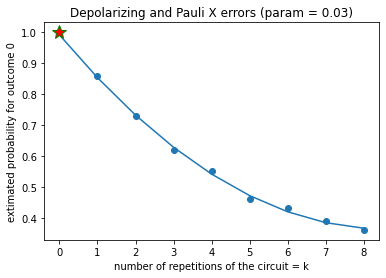

After error mitigation, probability (expectation value) for the outcome 1 = 0.011


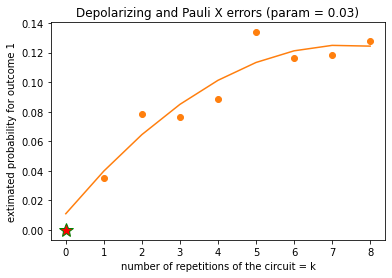

After error mitigation, probability (expectation value) for the outcome 2 = -0.001


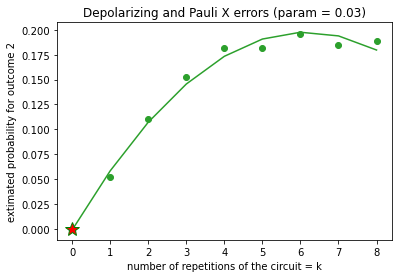

After error mitigation, probability (expectation value) for the outcome 3 = -0.01


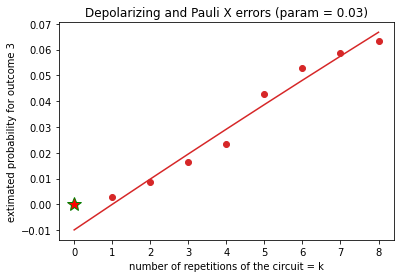

After error mitigation, probability (expectation value) for the outcome 4 = 0.006


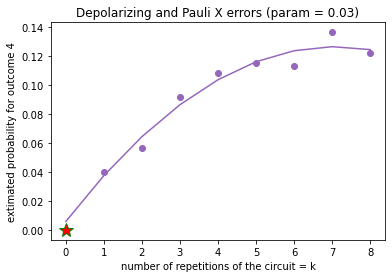

After error mitigation, probability (expectation value) for the outcome 5 = 0.004


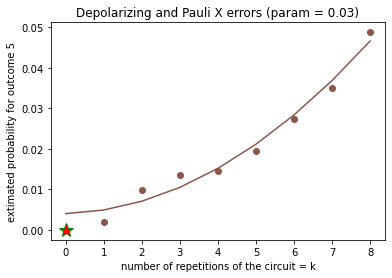

After error mitigation, probability (expectation value) for the outcome 6 = -0.001


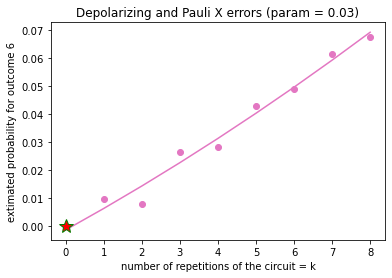

After error mitigation, probability (expectation value) for the outcome 7 = -0.0


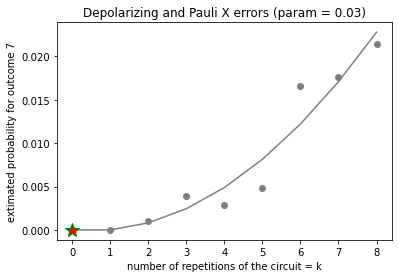

In [12]:
for outcome in range(dim):
    plot(prob_noise_list[:,outcome], outcome)

In [13]:
print(f'extimated prob_ideal = {prob_ideal}')

extimated prob_ideal = [1. 0. 0. 0. 0. 0. 0. 0.]


# 